<a href="https://www.kaggle.com/code/khoatran311/traffic-volume-data-processing?scriptVersionId=260547630" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import polars as pl
import polars.selectors as pls
import seaborn as sea
import matplotlib.pyplot as plt
import datetime
import scipy.stats as stats
from scipy.interpolate import CubicSpline

import warnings
warnings.filterwarnings("ignore")

# Loading Data

In [2]:
def format_pl():
    """FLOAT DISPLAY FORMATTING"""
    pl.Config.set_fmt_float("mixed")
    """STRING FORMATTING"""
    pl.Config.set_fmt_str_lengths(50)
    """TABLE FORMATTING"""
    pl.Config.set_tbl_rows(8)
    pl.Config.set_tbl_cols(15)
    pl.Config.set_tbl_width_chars(200)
    pl.Config.set_tbl_cell_alignment("RIGHT")
    pl.Config.set_tbl_hide_dtype_separator(True)
    pl.Config.set_tbl_hide_column_data_types(True)

format_pl()

In [3]:
data = pl.read_csv("/kaggle/input/metro-interstate-traffic-volume/Metro_Interstate_Traffic_Volume.csv")
print(f"Data's shape: {data.shape}")
print(data.head(4))
print(data.tail(4))

Data's shape: (48204, 9)
shape: (4, 9)
┌─────────┬────────┬─────────┬─────────┬────────────┬──────────────┬─────────────────────┬─────────────────────┬────────────────┐
│ holiday ┆   temp ┆ rain_1h ┆ snow_1h ┆ clouds_all ┆ weather_main ┆ weather_description ┆           date_time ┆ traffic_volume │
╞═════════╪════════╪═════════╪═════════╪════════════╪══════════════╪═════════════════════╪═════════════════════╪════════════════╡
│    None ┆ 288.28 ┆     0.0 ┆     0.0 ┆         40 ┆       Clouds ┆    scattered clouds ┆ 2012-10-02 09:00:00 ┆           5545 │
│    None ┆ 289.36 ┆     0.0 ┆     0.0 ┆         75 ┆       Clouds ┆       broken clouds ┆ 2012-10-02 10:00:00 ┆           4516 │
│    None ┆ 289.58 ┆     0.0 ┆     0.0 ┆         90 ┆       Clouds ┆     overcast clouds ┆ 2012-10-02 11:00:00 ┆           4767 │
│    None ┆ 290.13 ┆     0.0 ┆     0.0 ┆         90 ┆       Clouds ┆     overcast clouds ┆ 2012-10-02 12:00:00 ┆           5026 │
└─────────┴────────┴─────────┴─────────┴───────────

In [4]:
for feature,dtype in zip(data.columns, data.dtypes):
    print(f"Feature: {feature}")
    print(f"Data Type: {dtype}\n")

Feature: holiday
Data Type: String

Feature: temp
Data Type: Float64

Feature: rain_1h
Data Type: Float64

Feature: snow_1h
Data Type: Float64

Feature: clouds_all
Data Type: Int64

Feature: weather_main
Data Type: String

Feature: weather_description
Data Type: String

Feature: date_time
Data Type: String

Feature: traffic_volume
Data Type: Int64



In [5]:
## Changes type of datetime feature
data = data.with_columns(
    pl.col("date_time").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S").alias("date_time")
)

## Rename features
data = data.rename(
    {
        "temp":"temp_kelvin",
        "rain_1h":"rain_1h_mm",
        "snow_1h":"snow_1h_mm",
        "clouds_all":"cloud_pct",
        "weather_description":"weather_desc",
        "date_time":"datetime"
    }
)

data

holiday,temp_kelvin,rain_1h_mm,snow_1h_mm,cloud_pct,weather_main,weather_desc,datetime,traffic_volume
"""None""",288.28,0.0,0.0,40,"""Clouds""","""scattered clouds""",2012-10-02 09:00:00,5545
"""None""",289.36,0.0,0.0,75,"""Clouds""","""broken clouds""",2012-10-02 10:00:00,4516
"""None""",289.58,0.0,0.0,90,"""Clouds""","""overcast clouds""",2012-10-02 11:00:00,4767
"""None""",290.13,0.0,0.0,90,"""Clouds""","""overcast clouds""",2012-10-02 12:00:00,5026
…,…,…,…,…,…,…,…,…
"""None""",282.76,0.0,0.0,90,"""Clouds""","""overcast clouds""",2018-09-30 20:00:00,2781
"""None""",282.73,0.0,0.0,90,"""Thunderstorm""","""proximity thunderstorm""",2018-09-30 21:00:00,2159
"""None""",282.09,0.0,0.0,90,"""Clouds""","""overcast clouds""",2018-09-30 22:00:00,1450
"""None""",282.12,0.0,0.0,90,"""Clouds""","""overcast clouds""",2018-09-30 23:00:00,954


In [6]:
## NA count
data.select(
    pl.all().is_null().sum()
)

holiday,temp_kelvin,rain_1h_mm,snow_1h_mm,cloud_pct,weather_main,weather_desc,datetime,traffic_volume
0,0,0,0,0,0,0,0,0


In [7]:
## Unique count
data.select(
    pl.all().n_unique().sum()
).unpivot(
    value_name="unique_count"
).sort(by="unique_count", descending=True)

variable,unique_count
"""datetime""",40575
"""traffic_volume""",6704
"""temp_kelvin""",5843
"""rain_1h_mm""",372
…,…
"""weather_desc""",38
"""holiday""",12
"""snow_1h_mm""",12
"""weather_main""",11


## Categorical Data Analysis
### 1. Created category "rare weather" for **weather_desc** values occurring less than 50 times
### 2. Concatenated **weather_main** and **weather_desc** together, creating a new feature

In [8]:
cat_data = data.select(pl.col(pl.Utf8))

In [9]:
for feature in cat_data.columns:
    df = data.group_by(feature).agg(
    pl.col(feature).count().alias("count"),
    ).with_columns(
        (pl.col("count")/pl.col("count").sum()).alias("prop")
    ).sort(by="count", descending=True)
    print(df)
    print()

shape: (12, 3)
┌───────────────────────────┬───────┬──────────┐
│                   holiday ┆ count ┆     prop │
╞═══════════════════════════╪═══════╪══════════╡
│                      None ┆ 48143 ┆ 0.998735 │
│                 Labor Day ┆     7 ┆ 0.000145 │
│ Martin Luther King Jr Day ┆     6 ┆ 0.000124 │
│             Christmas Day ┆     6 ┆ 0.000124 │
│                         … ┆     … ┆        … │
│          Independence Day ┆     5 ┆ 0.000104 │
│              Columbus Day ┆     5 ┆ 0.000104 │
│                State Fair ┆     5 ┆ 0.000104 │
│              Veterans Day ┆     5 ┆ 0.000104 │
└───────────────────────────┴───────┴──────────┘

shape: (11, 3)
┌──────────────┬───────┬──────────┐
│ weather_main ┆ count ┆     prop │
╞══════════════╪═══════╪══════════╡
│       Clouds ┆ 15164 ┆  0.31458 │
│        Clear ┆ 13391 ┆ 0.277799 │
│         Mist ┆  5950 ┆ 0.123434 │
│         Rain ┆  5672 ┆ 0.117667 │
│            … ┆     … ┆        … │
│ Thunderstorm ┆  1034 ┆ 0.021451 │
│       

In [10]:
df = data.group_by(pl.col("weather_desc")).agg(
    pl.col("weather_desc").count().alias("count"),
).with_columns(
    (pl.col("count")/pl.col("count").sum()).alias("prop")
).sort(by="count", descending=True)

for desc,count,prop in zip(df["weather_desc"].to_list(), df["count"].to_list(), df["prop"].to_list()):
    print(f"Description:  {desc}")
    print(f"Count:        {count}")
    print(f"Proportion:   {prop:.3f}\n")

Description:  sky is clear
Count:        11665
Proportion:   0.242

Description:  mist
Count:        5950
Proportion:   0.123

Description:  overcast clouds
Count:        5081
Proportion:   0.105

Description:  broken clouds
Count:        4666
Proportion:   0.097

Description:  scattered clouds
Count:        3461
Proportion:   0.072

Description:  light rain
Count:        3372
Proportion:   0.070

Description:  few clouds
Count:        1956
Proportion:   0.041

Description:  light snow
Count:        1946
Proportion:   0.040

Description:  Sky is Clear
Count:        1726
Proportion:   0.036

Description:  moderate rain
Count:        1664
Proportion:   0.035

Description:  haze
Count:        1360
Proportion:   0.028

Description:  light intensity drizzle
Count:        1100
Proportion:   0.023

Description:  fog
Count:        912
Proportion:   0.019

Description:  proximity thunderstorm
Count:        673
Proportion:   0.014

Description:  drizzle
Count:        651
Proportion:   0.014

Des

In [11]:
### Obtain values with count < 1000 (rare descriptions)
rare_desc = set([
    desc for desc,count in zip(df["weather_desc"].to_list(), df["count"].to_list()) 
    if count < 1000
])

### Encode any values in rare_desc as "rare weather"
new_data = data.with_columns(
    pl.when(pl.col("weather_desc").is_in(rare_desc))
    .then(pl.lit("rare weather"))
    .otherwise(pl.col("weather_desc"))
    .alias("weather_desc")
)


## Combine weather description columns together
new_data = new_data.with_columns(
    (pl.col("weather_main") + "__" + pl.col("weather_desc")).alias("weather_main_desc_combined")
)

In [12]:
df = new_data.group_by(
    pl.col("weather_main_desc_combined")
).agg(
    pl.col("weather_main_desc_combined").count().alias("count")
).sort(
    by="count", descending=True
)

for desc,count in zip(df["weather_main_desc_combined"].to_list(), 
                      df["count"].to_list()):
    print(f"Description:  {desc}")
    print(f"Count:        {count}")

Description:  Clear__sky is clear
Count:        11665
Description:  Mist__mist
Count:        5950
Description:  Clouds__overcast clouds
Count:        5081
Description:  Clouds__broken clouds
Count:        4666
Description:  Clouds__scattered clouds
Count:        3461
Description:  Rain__light rain
Count:        3372
Description:  Clouds__few clouds
Count:        1956
Description:  Snow__light snow
Count:        1946
Description:  Clear__Sky is Clear
Count:        1726
Description:  Rain__moderate rain
Count:        1664
Description:  Haze__haze
Count:        1360
Description:  Drizzle__light intensity drizzle
Count:        1100
Description:  Thunderstorm__rare weather
Count:        1034
Description:  Snow__rare weather
Count:        930
Description:  Fog__rare weather
Count:        912
Description:  Drizzle__rare weather
Count:        721
Description:  Rain__rare weather
Count:        636
Description:  Smoke__rare weather
Count:        20
Description:  Squall__rare weather
Count:      

In [13]:
new_data.head(3)

holiday,temp_kelvin,rain_1h_mm,snow_1h_mm,cloud_pct,weather_main,weather_desc,datetime,traffic_volume,weather_main_desc_combined
"""None""",288.28,0.0,0.0,40,"""Clouds""","""scattered clouds""",2012-10-02 09:00:00,5545,"""Clouds__scattered clouds"""
"""None""",289.36,0.0,0.0,75,"""Clouds""","""broken clouds""",2012-10-02 10:00:00,4516,"""Clouds__broken clouds"""
"""None""",289.58,0.0,0.0,90,"""Clouds""","""overcast clouds""",2012-10-02 11:00:00,4767,"""Clouds__overcast clouds"""


## Numerical Data Anlysis
### 1. Resampled the data to follow a consistent 1-hour interval
### 2. Filtered only data after 2016/1/1 to use (earlier data contain large gaps of missing values)
### 3. Interpolated missing numeric values with Cubic Spline
### 4. Interpolated missing categorical values with forward and backward filling

In [14]:
new_data.with_columns(
    pl.col("datetime").diff().alias("diff_datetime")
).group_by(
    pl.col("diff_datetime")
).agg(
    pl.col("diff_datetime").count().alias("count")
).sort(by="diff_datetime", descending=True).to_pandas()

,diff_datetime,count
0,NaT,0
1,307 days 19:00:00,1
2,10 days 03:00:00,1
3,4 days 22:00:00,1
4,4 days 21:00:00,1
5,3 days 21:00:00,1
6,2 days 17:00:00,1
7,1 days 23:00:00,1
8,1 days 10:00:00,1
9,1 days 09:00:00,1


In [15]:
new_data.with_columns(
    pl.col("datetime").diff().alias("diff_datetime")
).filter(
    pl.col("diff_datetime")==datetime.timedelta(days=307, seconds=68400)
)

holiday,temp_kelvin,rain_1h_mm,snow_1h_mm,cloud_pct,weather_main,weather_desc,datetime,traffic_volume,weather_main_desc_combined,diff_datetime
"""None""",287.586,0.0,0.0,92,"""Rain""","""light rain""",2015-06-11 20:00:00,2886,"""Rain__light rain""",307d 19h


In [16]:
"""Filters the data to contain dates after 2015-06-12 only (eliminates the large break in the datetime interval)"""
new_data = new_data.filter(
    pl.col("datetime") >= datetime.datetime(2015, 6, 12, 0)
)
new_data

holiday,temp_kelvin,rain_1h_mm,snow_1h_mm,cloud_pct,weather_main,weather_desc,datetime,traffic_volume,weather_main_desc_combined
"""None""",297.543,0.0,0.0,0,"""Clear""","""Sky is Clear""",2015-06-12 18:00:00,4380,"""Clear__Sky is Clear"""
"""None""",292.061,0.0,0.0,8,"""Clear""","""sky is clear""",2015-06-12 20:00:00,3095,"""Clear__sky is clear"""
"""None""",292.061,0.0,0.0,8,"""Clear""","""sky is clear""",2015-06-12 21:00:00,3299,"""Clear__sky is clear"""
"""None""",294.84,0.0,0.0,76,"""Clouds""","""broken clouds""",2015-06-13 21:00:00,3040,"""Clouds__broken clouds"""
…,…,…,…,…,…,…,…,…,…
"""None""",282.76,0.0,0.0,90,"""Clouds""","""overcast clouds""",2018-09-30 20:00:00,2781,"""Clouds__overcast clouds"""
"""None""",282.73,0.0,0.0,90,"""Thunderstorm""","""rare weather""",2018-09-30 21:00:00,2159,"""Thunderstorm__rare weather"""
"""None""",282.09,0.0,0.0,90,"""Clouds""","""overcast clouds""",2018-09-30 22:00:00,1450,"""Clouds__overcast clouds"""
"""None""",282.12,0.0,0.0,90,"""Clouds""","""overcast clouds""",2018-09-30 23:00:00,954,"""Clouds__overcast clouds"""


In [17]:
"""Inspects uniformity in sampling interval for values"""

new_data.with_columns(
    pl.col("datetime").diff().alias("diff_datetime")
).group_by(
    pl.col("diff_datetime")
).agg(
    pl.col("diff_datetime").count().alias("count")
).sort(by="diff_datetime", descending=True).to_pandas()

,diff_datetime,count
0,NaT,0
1,4 days 22:00:00,1
2,3 days 21:00:00,1
3,1 days 10:00:00,1
4,1 days 06:00:00,1
5,1 days 00:00:00,2
6,0 days 21:00:00,1
7,0 days 18:00:00,1
8,0 days 14:00:00,1
9,0 days 10:00:00,4


In [18]:
"""
1. Remove data entries with 0 changes in datetime (possible duplicates)
2. Drops diff_datetime feature
"""
new_data = new_data.with_columns(
    pl.col("datetime").diff().alias("diff_datetime")
).filter(
    pl.col("diff_datetime")!=0
).drop("diff_datetime")

new_data

holiday,temp_kelvin,rain_1h_mm,snow_1h_mm,cloud_pct,weather_main,weather_desc,datetime,traffic_volume,weather_main_desc_combined
"""None""",292.061,0.0,0.0,8,"""Clear""","""sky is clear""",2015-06-12 20:00:00,3095,"""Clear__sky is clear"""
"""None""",292.061,0.0,0.0,8,"""Clear""","""sky is clear""",2015-06-12 21:00:00,3299,"""Clear__sky is clear"""
"""None""",294.84,0.0,0.0,76,"""Clouds""","""broken clouds""",2015-06-13 21:00:00,3040,"""Clouds__broken clouds"""
"""None""",293.137,0.0,0.0,56,"""Clouds""","""broken clouds""",2015-06-13 23:00:00,2051,"""Clouds__broken clouds"""
…,…,…,…,…,…,…,…,…,…
"""None""",282.76,0.0,0.0,90,"""Clouds""","""overcast clouds""",2018-09-30 20:00:00,2781,"""Clouds__overcast clouds"""
"""None""",282.73,0.0,0.0,90,"""Thunderstorm""","""rare weather""",2018-09-30 21:00:00,2159,"""Thunderstorm__rare weather"""
"""None""",282.09,0.0,0.0,90,"""Clouds""","""overcast clouds""",2018-09-30 22:00:00,1450,"""Clouds__overcast clouds"""
"""None""",282.12,0.0,0.0,90,"""Clouds""","""overcast clouds""",2018-09-30 23:00:00,954,"""Clouds__overcast clouds"""


In [19]:
"""Resamples the data to contain uniform 1hr sampling rate"""

min_time, max_time = new_data["datetime"].min(), new_data["datetime"].max()

full_range = pl.DataFrame(
    {"datetime":pl.datetime_range(min_time, max_time, "1h", eager=True)}
)

resampled_data = full_range.join(new_data, on="datetime", how="left")
resampled_data

datetime,holiday,temp_kelvin,rain_1h_mm,snow_1h_mm,cloud_pct,weather_main,weather_desc,traffic_volume,weather_main_desc_combined
2015-06-12 20:00:00,"""None""",292.061,0.0,0.0,8,"""Clear""","""sky is clear""",3095,"""Clear__sky is clear"""
2015-06-12 21:00:00,"""None""",292.061,0.0,0.0,8,"""Clear""","""sky is clear""",3299,"""Clear__sky is clear"""
2015-06-12 22:00:00,null,null,null,null,null,null,null,null,null
2015-06-12 23:00:00,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…
2018-09-30 20:00:00,"""None""",282.76,0.0,0.0,90,"""Clouds""","""overcast clouds""",2781,"""Clouds__overcast clouds"""
2018-09-30 21:00:00,"""None""",282.73,0.0,0.0,90,"""Thunderstorm""","""rare weather""",2159,"""Thunderstorm__rare weather"""
2018-09-30 22:00:00,"""None""",282.09,0.0,0.0,90,"""Clouds""","""overcast clouds""",1450,"""Clouds__overcast clouds"""
2018-09-30 23:00:00,"""None""",282.12,0.0,0.0,90,"""Clouds""","""overcast clouds""",954,"""Clouds__overcast clouds"""


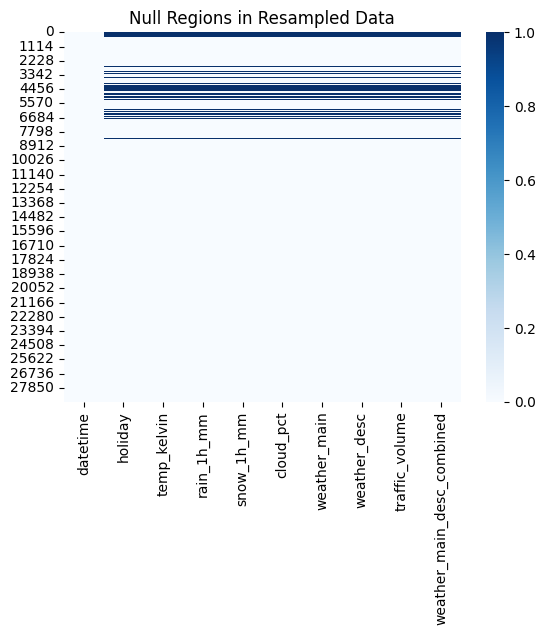

In [20]:
sea.heatmap(resampled_data.to_pandas().isnull(), cmap="Blues")
plt.title("Null Regions in Resampled Data")
plt.show()

In [21]:
"""
Finds the count of NA values in each feature per each year-month-day
1. The max number of missing values per datetime is 24
2. The datetime with the most missing values after resampling is 2015-06 and 2015-10 data
"""
NA_counts = resampled_data.with_columns(
    pl.col("datetime").dt.strftime("%Y-%m-%d").alias("year_month_day")
).with_columns(
    pl.col("year_month_day").str.strptime(pl.Datetime, "%Y-%m-%d")
).group_by(
    pl.col("year_month_day")
).agg(
    pl.all().is_null().sum()
).sort(
    by="year_month_day",
    descending=False
)#.filter(
#     pl.col("holiday")>0
# )

high_NA_counts = NA_counts.filter(
    pl.col("holiday")==24
).to_pandas()


display(NA_counts)
display(high_NA_counts)

year_month_day,datetime,holiday,temp_kelvin,rain_1h_mm,snow_1h_mm,cloud_pct,weather_main,weather_desc,traffic_volume,weather_main_desc_combined
2015-06-12 00:00:00,0,2,2,2,2,2,2,2,2,2
2015-06-13 00:00:00,0,22,22,22,22,22,22,22,22,22
2015-06-14 00:00:00,0,23,23,23,23,23,23,23,23,23
2015-06-15 00:00:00,0,24,24,24,24,24,24,24,24,24
…,…,…,…,…,…,…,…,…,…,…
2018-09-27 00:00:00,0,0,0,0,0,0,0,0,0,0
2018-09-28 00:00:00,0,0,0,0,0,0,0,0,0,0
2018-09-29 00:00:00,0,0,0,0,0,0,0,0,0,0
2018-09-30 00:00:00,0,0,0,0,0,0,0,0,0,0


,year_month_day,datetime,holiday,temp_kelvin,rain_1h_mm,snow_1h_mm,cloud_pct,weather_main,weather_desc,traffic_volume,weather_main_desc_combined
0,2015-06-15,0,24,24,24,24,24,24,24,24,24
1,2015-06-16,0,24,24,24,24,24,24,24,24,24
2,2015-06-17,0,24,24,24,24,24,24,24,24,24
3,2015-06-18,0,24,24,24,24,24,24,24,24,24
4,2015-06-21,0,24,24,24,24,24,24,24,24,24
5,2015-06-23,0,24,24,24,24,24,24,24,24,24
6,2015-10-24,0,24,24,24,24,24,24,24,24,24
7,2015-10-25,0,24,24,24,24,24,24,24,24,24
8,2015-10-26,0,24,24,24,24,24,24,24,24,24


In [22]:
"""
Takes data from 2016-4-1 and onward only, which contain fewer NA values
"""
resampled_data = resampled_data.with_columns(
    pl.col("datetime").dt.strftime("%Y-%m-%d").alias("year_month_day")
).with_columns(
    pl.col("year_month_day").str.strptime(pl.Datetime, "%Y-%m-%d")
).filter(
    pl.col("year_month_day")>=datetime.datetime(2016, 4, 1)
).drop(
    pl.col("year_month_day")
)

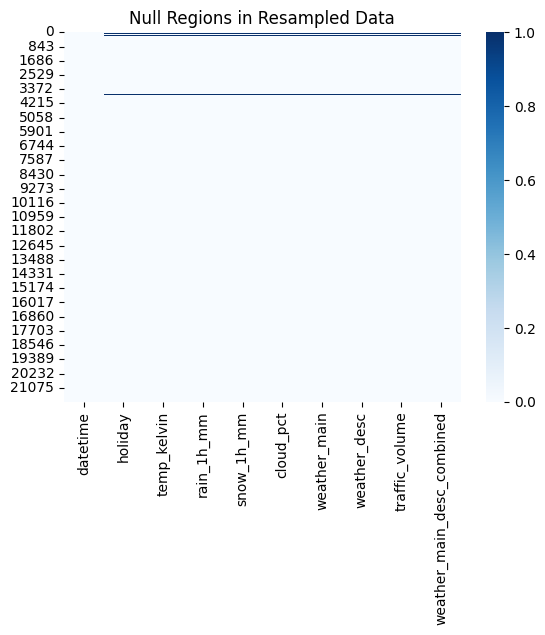

In [23]:
sea.heatmap(resampled_data.to_pandas().isnull(), cmap="Blues")
plt.title("Null Regions in Resampled Data")
plt.show()

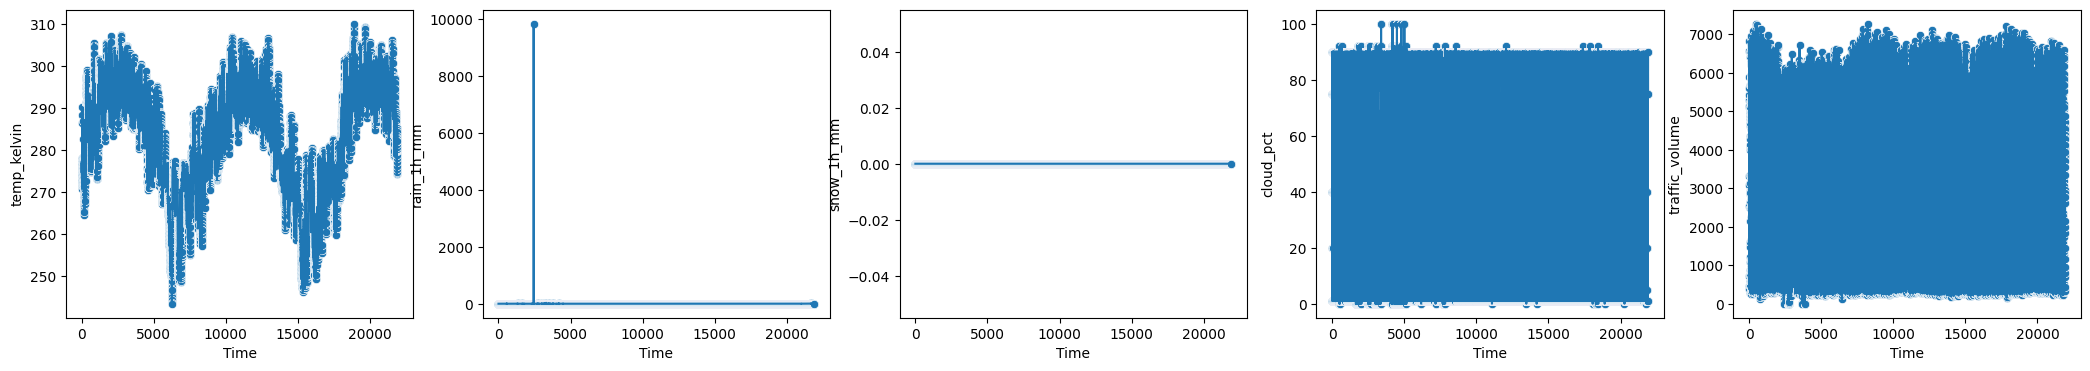

In [24]:
plt.figure(figsize=(26,4))
for k,feature in enumerate(["temp_kelvin", "rain_1h_mm", "snow_1h_mm", "cloud_pct", "traffic_volume"]):
    plt.subplot(1, 5, k+1)
    sea.scatterplot(x=np.arange(0,21_912), y=resampled_data[feature])
    sea.lineplot(x=np.arange(0,21_912), y=resampled_data[feature])
    plt.xlabel("Time")
    plt.ylabel(feature)
plt.show()

In [25]:
def interpolate_log_scale(time_arr, target_arr):
    ## Masks out NA values
    mask = ~np.isnan(target_arr)
    ## avoid log(0) -- add small eps or handle zeros explicitly
    eps = 1e-6
    y  = np.log(target_arr[mask] + eps)
    model  = CubicSpline(time_arr[mask], y, extrapolate=False)
    y_pred = model(time_arr)
    filled = target_arr.copy()
    filled[np.isnan(target_arr)] = np.exp(y_pred[np.isnan(target_arr)]) - eps
    return np.round(filled, 5)

In [26]:
resampled_data = resampled_data.with_columns(
    pl.Series(
        "temp_kelvin", 
        interpolate_log_scale(
            np.array(resampled_data["datetime"]),
            np.array(resampled_data["temp_kelvin"])
        )
    )
)

resampled_data = resampled_data.with_columns(
    pl.col("rain_1h_mm").fill_null(strategy="backward").fill_null(strategy="forward"),
    pl.col("snow_1h_mm").fill_null(strategy="backward").fill_null(strategy="forward"),
    pl.col("traffic_volume").fill_null(strategy="backward").fill_null(strategy="forward"),
    pl.col("cloud_pct").fill_null(strategy="backward").fill_null(strategy="forward"),
)

In [27]:
"""
Applies Forward and Backward filling for EXOGENOUS CATEGORICAL VARIABLES
"""
resampled_data = resampled_data.with_columns(
    [pl.col(feature).fill_null(strategy="forward").fill_null(strategy="backward")
     for feature in ["weather_main", "weather_desc", "weather_main_desc_combined"]
    ]  
).with_columns(
    pl.col("holiday").fill_null(strategy="backward").fill_null(strategy="forward")
)

resampled_data

datetime,holiday,temp_kelvin,rain_1h_mm,snow_1h_mm,cloud_pct,weather_main,weather_desc,traffic_volume,weather_main_desc_combined
2016-04-01 00:00:00,"""None""",276.76,0.0,0.0,40,"""Clouds""","""scattered clouds""",731,"""Clouds__scattered clouds"""
2016-04-01 01:00:00,"""None""",275.62,0.0,0.0,1,"""Drizzle""","""light intensity drizzle""",458,"""Drizzle__light intensity drizzle"""
2016-04-01 02:00:00,"""None""",275.00266,0.0,0.0,75,"""Drizzle""","""light intensity drizzle""",378,"""Drizzle__light intensity drizzle"""
2016-04-01 03:00:00,"""None""",275.21,0.0,0.0,75,"""Mist""","""mist""",378,"""Mist__mist"""
…,…,…,…,…,…,…,…,…,…
2018-09-30 20:00:00,"""None""",282.76,0.0,0.0,90,"""Clouds""","""overcast clouds""",2781,"""Clouds__overcast clouds"""
2018-09-30 21:00:00,"""None""",282.73,0.0,0.0,90,"""Thunderstorm""","""rare weather""",2159,"""Thunderstorm__rare weather"""
2018-09-30 22:00:00,"""None""",282.09,0.0,0.0,90,"""Clouds""","""overcast clouds""",1450,"""Clouds__overcast clouds"""
2018-09-30 23:00:00,"""None""",282.12,0.0,0.0,90,"""Clouds""","""overcast clouds""",954,"""Clouds__overcast clouds"""


In [28]:
resampled_data.select(
    pl.all().is_null().sum()
)

datetime,holiday,temp_kelvin,rain_1h_mm,snow_1h_mm,cloud_pct,weather_main,weather_desc,traffic_volume,weather_main_desc_combined
0,0,0,0,0,0,0,0,0,0


In [29]:
# resampled_data = resampled_data.with_columns(
#     pl.when(pl.col("traffic_volume") <= 0)
#     .then(pl.col("traffic_volume").mean())
#     .otherwise(pl.col("traffic_volume"))
#     .alias("traffic_volume")
# )

In [30]:
resampled_data = resampled_data.select(
    pl.exclude("snow_1h_mm")
)

# Saves Data File

In [31]:
resampled_data.to_pandas().to_csv("resampled_data.csv", index=False)